Using this corrosion dataset, we will try to create a classifier model using various ML models that will predict the Rate/Extent of corrosion for a given material under provided conditions of environment, temperature, concentration and duration.

**Importing all the necessary libraries to preprocess the data**







In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import sys
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing the dataset from the system

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Project_Files/CORR-DATA_Database.csv')
data.head()

,Environment,Material Group,Material Family,Material,Rate (mm/yr) or Rating,Rate (mils/yr) or Rating,Localized Attack,UNS,Condition/Comment,Concentration (Vol %),Temperature (deg C),Temperature (deg F),Duration,Reference #,Reference
0,Acetaldehyde,Miscellaneous,Magnesium and alloys,Magnesium,D (Poor),D (Poor),NaN,NaN,NaN,All,NaN,NaN,NaN,119.0,"Dow Chemical Co., Midland, MI"
1,Acetaldehyde,Miscellaneous,Noble metals,Platinum,0.05 max,2 max,NaN,P04995,NaN,Pure,200-400,390-750,NaN,6.0,"Metals Handbook, Ninth Edition, Vol 13, Corros..."
2,Acetaldehyde,Miscellaneous,Noble metals,Silver,0.05 max,2 max,NaN,P07010,NaN,Pure,200-400,390-750,NaN,10.0,"Metals Handbook, Ninth Edition, Vol 13, Corros..."
3,Acetaldehyde,Refractory metals and alloys,Titanium and alloys,Titanium,0.001,0.04,NaN,NaN,NaN,75,149,300,NaN,90.0,"N.D. Tomashov and P.M. Altovskii, Corrosion an..."
4,Acetaldehyde,Refractory metals and alloys,Titanium and alloys,Titanium,A (Resistant),A (Resistant),NaN,NaN,NaN,100,149,300,NaN,90.0,"N.D. Tomashov and P.M. Altovskii, Corrosion an..."


On Visualizing the dataset, we can see that there are few irrevelant columns like -Localized Attack, UNS, Condition/comment, Reference# and Reference. So we will be removing these columns. Also, we will take rate(mm/year) and Temperature in degree celsius. So we will also remove the respective duplicate columns.

In [ ]:
data=data.drop(columns=['Reference','Reference #','Temperature (deg F)','Condition/Comment','Rate (mils/yr) or Rating','Localized Attack','UNS'])

Checking for the data description

In [ ]:
data.describe()

,Environment,Material Group,Material Family,Material,Rate (mm/yr) or Rating,Concentration (Vol %),Temperature (deg C),Duration
count,24721,24721,24721,24719,24354,15202,21335,4546
unique,288,16,90,817,962,423,495,340
top,Sulfuric Acid,Stainless steels,Austenitic,316,A (Resistant),10,Boiling,24 h
freq,2686,16119,10902,1414,9689,2180,6022,462


We can see that there are a lot of null values present in the dataset, so we will remove them and also clean our dataset manually, for e.g- by replacing the 'Boiling' in Temperature to the actual boiling point of the environment.

In [ ]:
data=data.dropna()

We will reset the index values of our rows, which were changed due to the dropping process.

In [ ]:
data=data.reset_index(drop=True)

We will rename the column names to much simpler names

In [ ]:
data=data.rename(columns={'Rate (mm/yr) or Rating':'Rate','Concentration (Vol %)':'Concentration','Temperature (deg C)':'Temperature'},inplace=False)
data.describe()

,Environment,Material Group,Material Family,Material,Rate,Concentration,Temperature,Duration
count,3046,3046,3046,3046,3046,3046,3046,3046
unique,92,11,50,329,555,261,273,245
top,Sulfuric Acid,Stainless steels,Austenitic,316,A (Resistant),10,Boiling,24 h
freq,531,1398,1285,475,270,299,471,416


We will first clean the Rate column by splitting the strings. We will then further split the 0th column with the delimiter having hyphen. We will have 2 columns having the range of the corrosion rate, so we will take an average of it. For those rows, having no range, simply the rate value will be evaluated. While, for those rows in which a range of rate is given, average will be calculated.

In [ ]:
Rate_1=data.Rate.str.split(expand=True)
Rate_1=Rate_1.drop(columns=1)
Rate_1=Rate_1.rename(columns={0:'rate'},inplace=False)
Rate_1=Rate_1.rate.str.split("-",expand=True)
Rate_1=Rate_1.rename(columns={0:'abc',1:'pqr'})
d=0
l=Rate_1.abc.count()
while(d<l):
    a=(Rate_1.abc.iloc[d])
    b=(Rate_1.pqr.iloc[d])
    if((type(b))==str):
        g=float(b)
        f=float(a)
        k=(f+g)/2
        Rate_1.abc.iloc[d]=k
    d=d+1
Rate_1=Rate_1.drop(columns='pqr')    

Rate_1.head()

,abc
0,0.003
1,0.1
2,A
3,A
4,0.003


As we can see there are some values that are given in Strings while some are given in floating point. So to make the dataset even, we will encode the numeric values into the respective strings by setting a threshold value. If the rate is < 0.002 it will be classified as 'A' (Very little corrosion). If rate >=0.002 and <0.02, it will be considered 'B'. If it is >0.02 and <0.05 then it will be considered 'C'. Finally, if it is greater than or equal to 0.05 it will be considered 'D' (Poor corrosion resistance).

In [ ]:

d=0
Rate_1['abc']=Rate_1['abc'].astype(str)
for i in Rate_1['abc']:
    if(i!= "A" and i!="B" and i!="C" and i!="D" and i!='0.1.'):
        k=float(i)
        if(k<0.002):
            Rate_1['abc'].loc[d]='A'
        elif(k>=0.002 and k<0.02):
            Rate_1['abc'].loc[d]='B'
        elif(k>=0.02 and k<0.05):
            Rate_1['abc'].loc[d]='C'
        else:
            Rate_1['abc'].loc[d]='D'
    d=d+1 
  

In [ ]:
Rate_1=Rate_1.rename(columns={'abc':'Rate'})  
Rate_1.head()

,Rate
0,B
1,D
2,A
3,A
4,B


Perfect, we now have a cleaned column for rate.

We will now clean the duration column. If the time is given in days, we will convert it into hours.

In [ ]:
Duration_1=data.Duration.str.split(expand=True)
Duration_1[0]=Duration_1[0].astype(float)
d=0
for i in Duration_1[1]:
    if(i=='d'):
        Duration_1[0].loc[d]= (Duration_1[0].loc[d] *24)
    d=d+1
Duration_1=Duration_1.drop(columns=1)
Duration_1=Duration_1.rename(columns={0:'Duration'})
Duration_1.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Duration
0,9936.0
1,4056.0
2,2400.0
3,5904.0
4,1944.0


Our 2 columns- Temperature and Concentartion have many vague entries and some discrepancies that cannot be corrected through code. So we will save these 2 columns in a separate csv files and manually clean them.

In [ ]:
data.to_csv('Data_1')

We will now load the concentration column and set it as average of the values where range is given

In [ ]:
conc=pd.read_csv('/content/drive/MyDrive/Project_Files/Concentration_edited.csv')
conc=conc.rename(columns={'Concentration_new':'Concentration'})
conc.head()


,Concentration
0,100
1,70
2,70
3,50
4,50


In [ ]:
conc=conc.Concentration.str.split('-',expand=True)
conc=conc.rename(columns={0:'Concentration',1:'pqr'})
d=0
l=conc.Concentration.count()
while(d<l):
    a=(conc.Concentration.iloc[d])
    b=(conc.pqr.iloc[d])
    if((type(b))==str):
        g=float(b)
        f=float(a)
        k=(f+g)/2
        conc.Concentration.loc[d]=k
    d=d+1
conc=conc.drop(columns='pqr')    
conc.head()

,Concentration
0,100
1,70
2,70
3,50
4,50


Now, we will load the edited temperature column.

In [ ]:
temp=pd.read_csv('/content/drive/MyDrive/Project_Files/Temperature_edited.csv')
temp=temp.rename(columns={'Temperature(edited_new)':'Temperature'})
temp.head()

,Temperature
0,61.0
1,118.0
2,104.0
3,92.0
4,92.0


Now, we will drop the previous versions of temperature, concentration, rate and duration (As they are unclean versions) and replace them with the cleaned columns.

In [ ]:

data=data.drop(columns=['Rate','Concentration','Temperature','Duration'])
data_cleaned=pd.concat([data,conc,temp,Duration_1,Rate_1],axis=1)
data_cleaned.head()

,Environment,Material Group,Material Family,Material,Concentration,Temperature,Duration,Rate
0,Acetaldehyde,Stainless steels,Austenitic,304,100,61.0,9936.0,B
1,Acetaldehyde,Stainless steels,Austenitic,316,70,118.0,4056.0,D
2,Acetaldehyde,Stainless steels,Austenitic,316,70,104.0,2400.0,A
3,Acetaldehyde,Stainless steels,Austenitic,316,50,92.0,5904.0,A
4,Acetaldehyde,Stainless steels,Austenitic,316,50,92.0,1944.0,B


In [ ]:
data_cleaned.dtypes

Environment         object
Material Group      object
Material Family     object
Material            object
Concentration       object
Temperature        float64
Duration           float64
Rate                object
dtype: object

We can see that our Concentration is in 'object' type. So, we will convert it into float

In [ ]:
data_cleaned.Concentration=data_cleaned.Concentration.astype(float)

In [ ]:
index_list = data_cleaned[data_cleaned['Rate'] == '0.1.'].index.tolist()
print(index_list)

[1014]


In [ ]:
data_cleaned=data_cleaned.drop(index=1014)

Now we will encode our data into integer, so as to build a classifier. We will using label encoding in which we will assign one label one integer, so that our classifier can understand it.

In [ ]:
number=LabelEncoder()
data_cleaned['Rate']=number.fit_transform(data_cleaned['Rate'].astype('str'))
data_cleaned['Environment']=number.fit_transform(data_cleaned['Environment'].astype('str'))
data_cleaned['Material Group']=number.fit_transform(data_cleaned['Material Group'].astype('str'))
data_cleaned['Material Family']=number.fit_transform(data_cleaned['Material Family'].astype('str'))
data_cleaned['Material']=number.fit_transform(data_cleaned['Material'].astype('str'))

We can see that we have 92 Environments,11 Material groups, 50 Material families and 329 Materials. We will encode them into a particular category using label encoder.

So, we have to predict the Rate using all the rest of the columns.

In [ ]:
x = data_cleaned.drop(columns = 'Rate')
y = data_cleaned['Rate']
data_cleaned.describe()

,Environment,Material Group,Material Family,Material,Concentration,Temperature,Duration,Rate
count,3045.000000,3045.000000,3045.000000,3045.000000,3045.000000,3045.000000,3045.000000,3045.000000
mean,58.460755,7.922496,15.907389,138.422332,36.615103,93.217143,1062.243048,2.041379
std,26.875232,2.578575,13.733979,90.133590,31.335620,89.972165,2297.167449,1.105889
min,0.000000,0.000000,0.000000,0.000000,0.000000,-27.100000,1.000000,0.000000
25%,41.000000,7.000000,4.000000,55.000000,10.000000,42.500000,24.000000,1.000000
50%,67.000000,8.000000,13.000000,116.000000,25.000000,80.000000,168.000000,3.000000
75%,78.000000,10.000000,29.000000,221.000000,60.000000,114.500000,996.000000,3.000000
max,91.000000,10.000000,49.000000,328.000000,357.500000,1327.000000,28272.000000,3.000000


Now, let's visualize the data using seaborn and matplotlib libraries.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

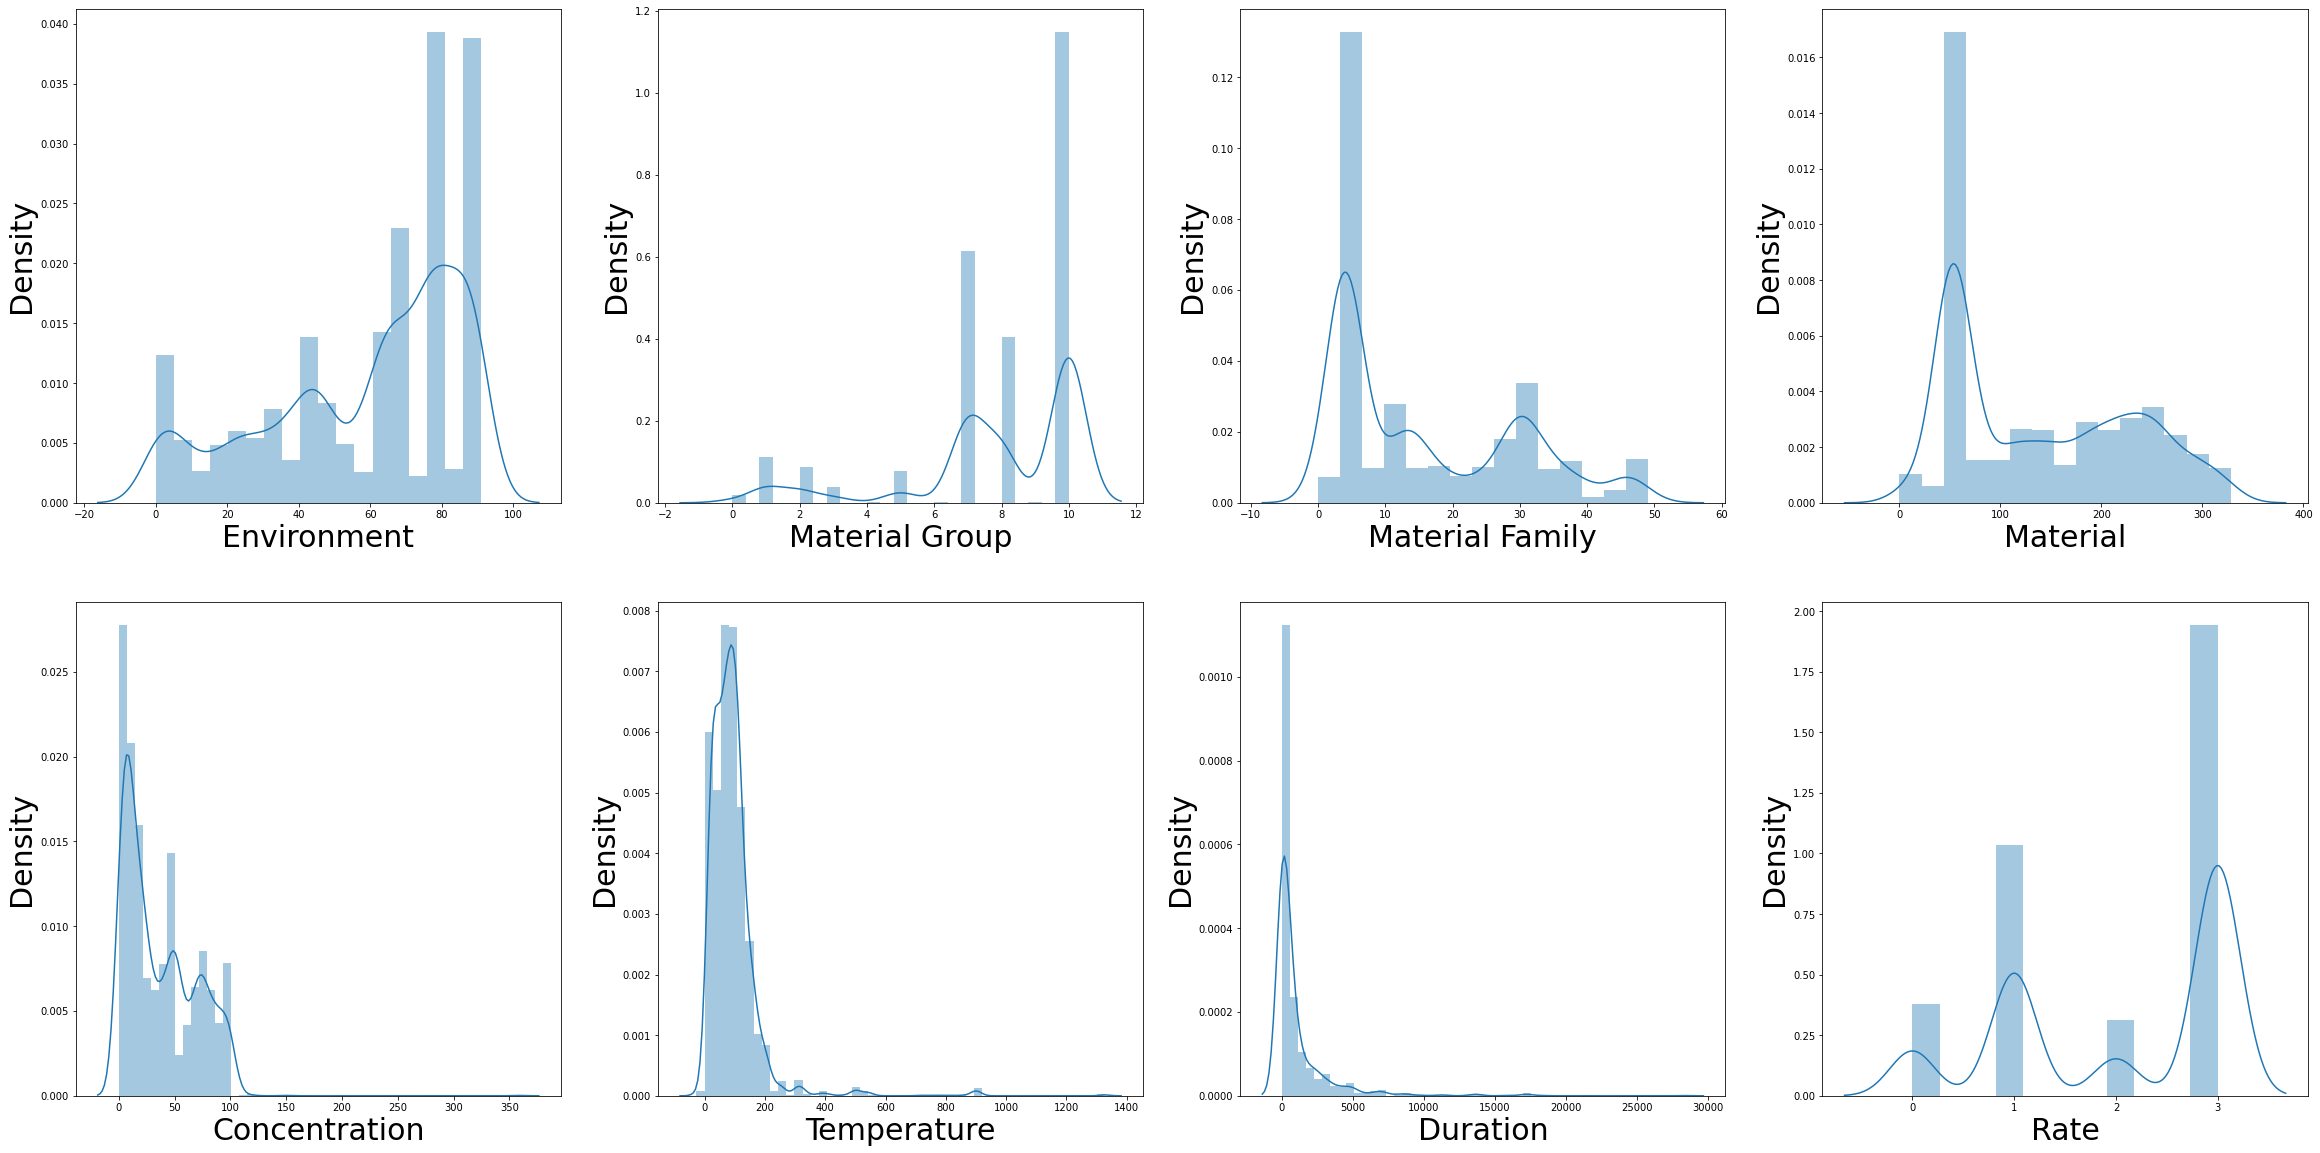

In [ ]:
x= plt.figure(figsize=(40,20), facecolor='white')
plotnumber = 1

for column in data_cleaned:
    if plotnumber<=8 :     # as there are 8 columns in the data
        ax = plt.subplot(2,4,plotnumber)
        sns.distplot(data_cleaned[column])
        plt.xlabel(column,fontsize=30)
        plt.ylabel('Density',fontsize=30)
    plotnumber+=1
x.show()
x.savefig('distribution_plot.png')

In [ ]:
plt.savefig('density_plot.png')

<Figure size 432x288 with 0 Axes>

Great, our datalooks perfect. Distribution is almost gaussian for the non-labelled data, which is exactly what we want.

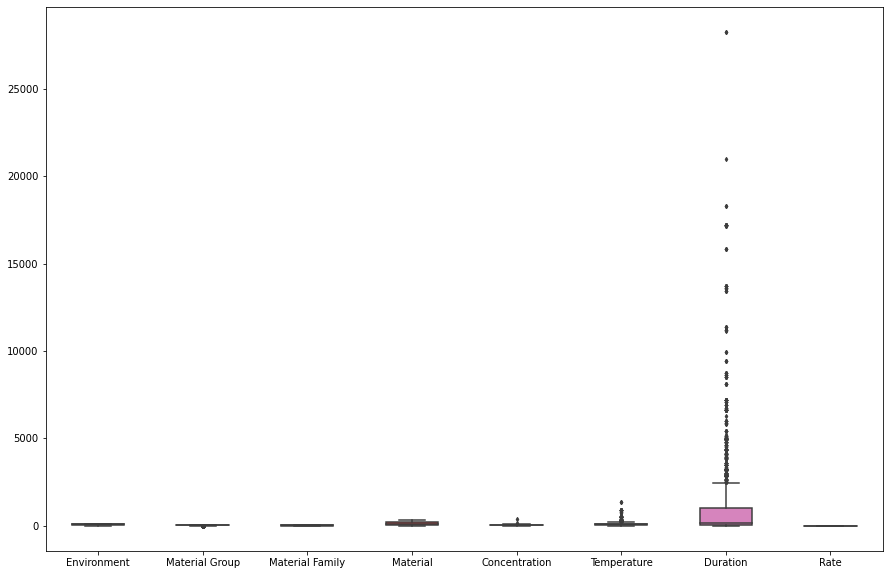

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data_cleaned, width= 0.5,ax=ax,  fliersize=3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

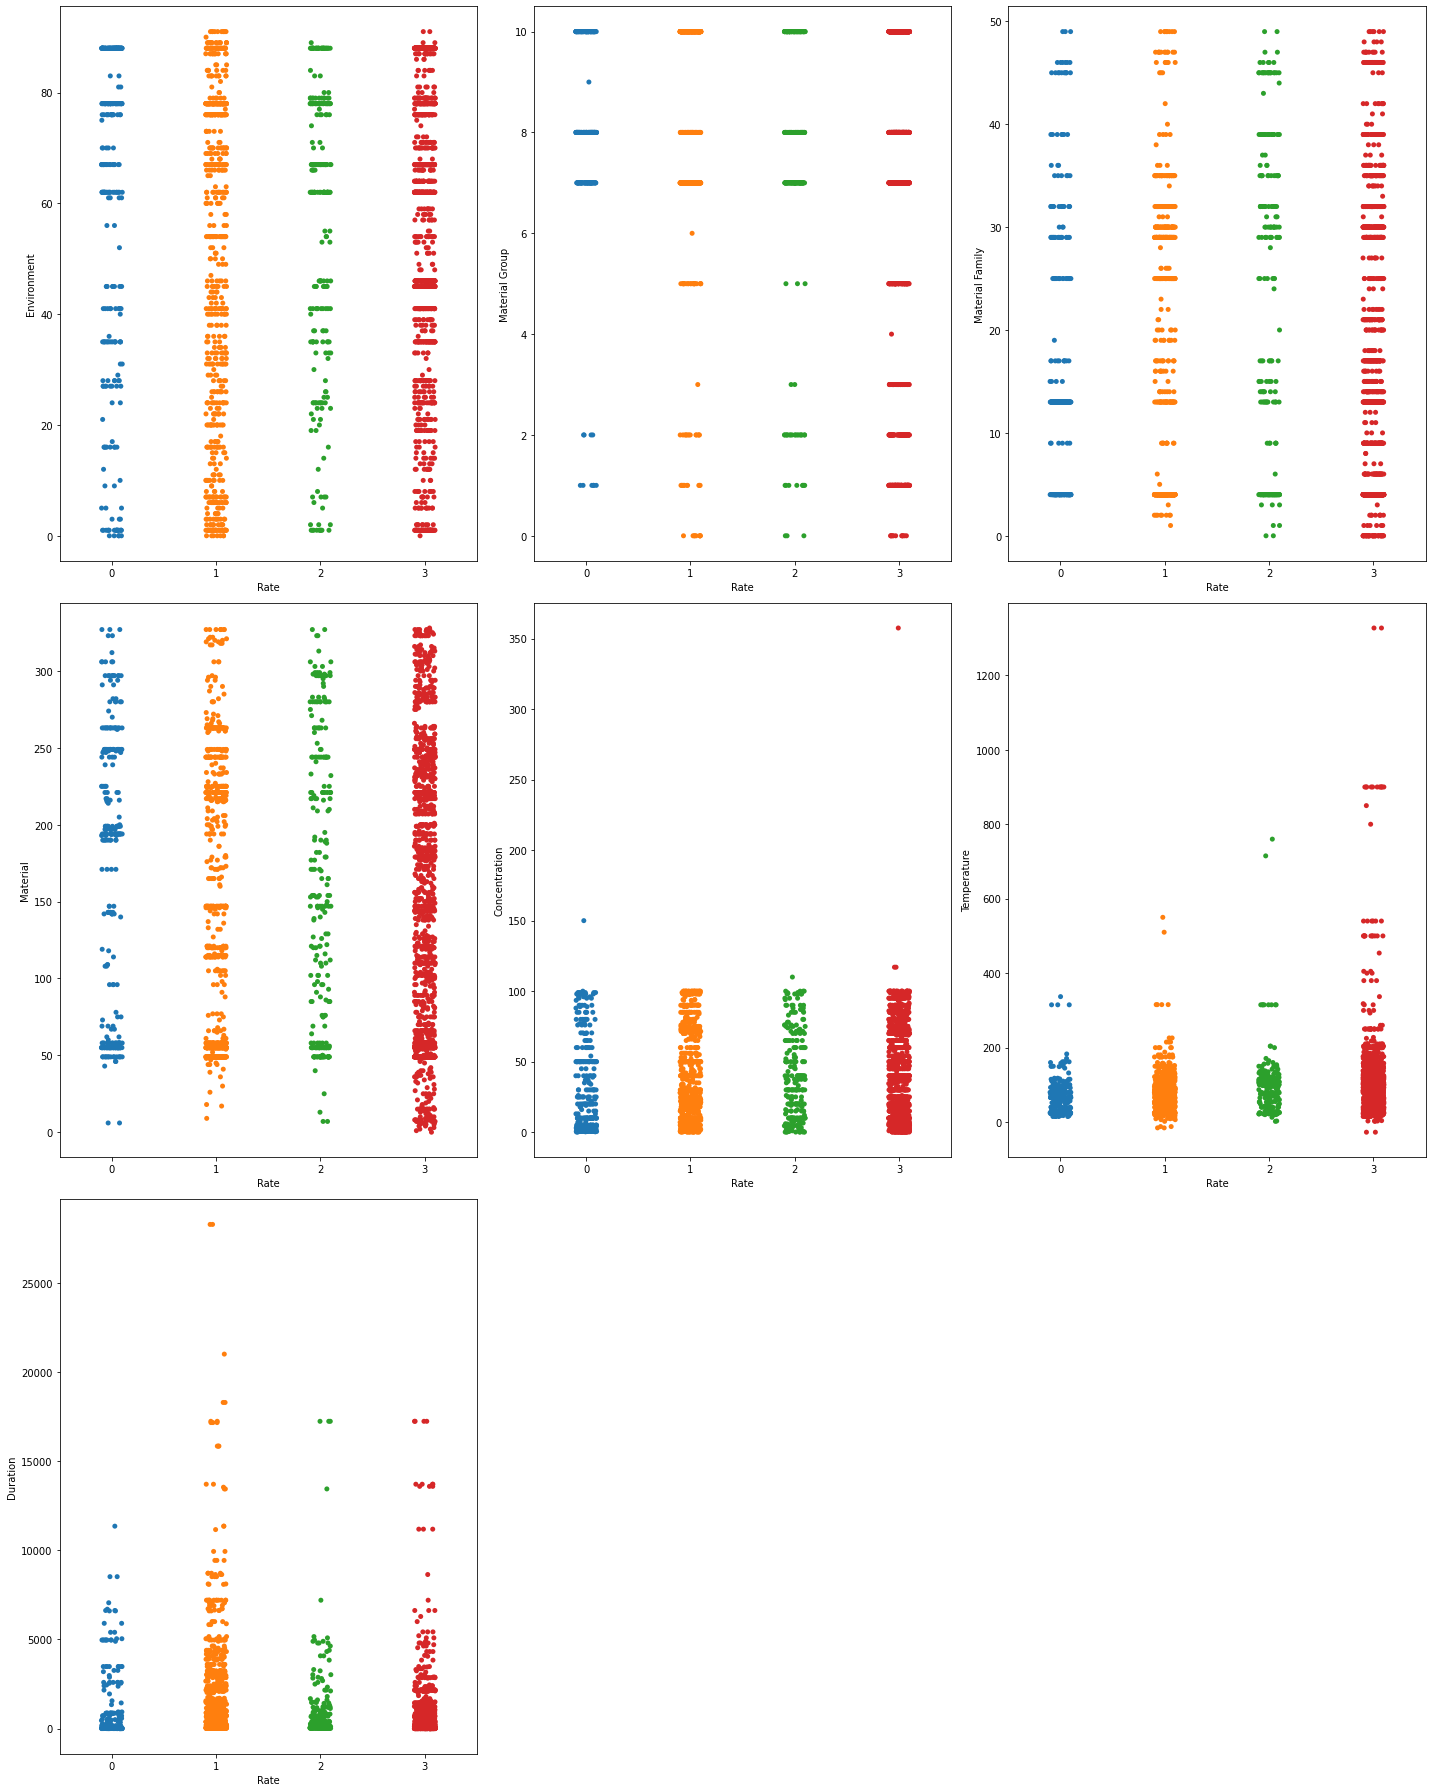

In [ ]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in x:
    if plotnumber<=8 :
        ax = plt.subplot(3,3,plotnumber)
        sns.stripplot(y,x[column])
    plotnumber+=1
plt.tight_layout()

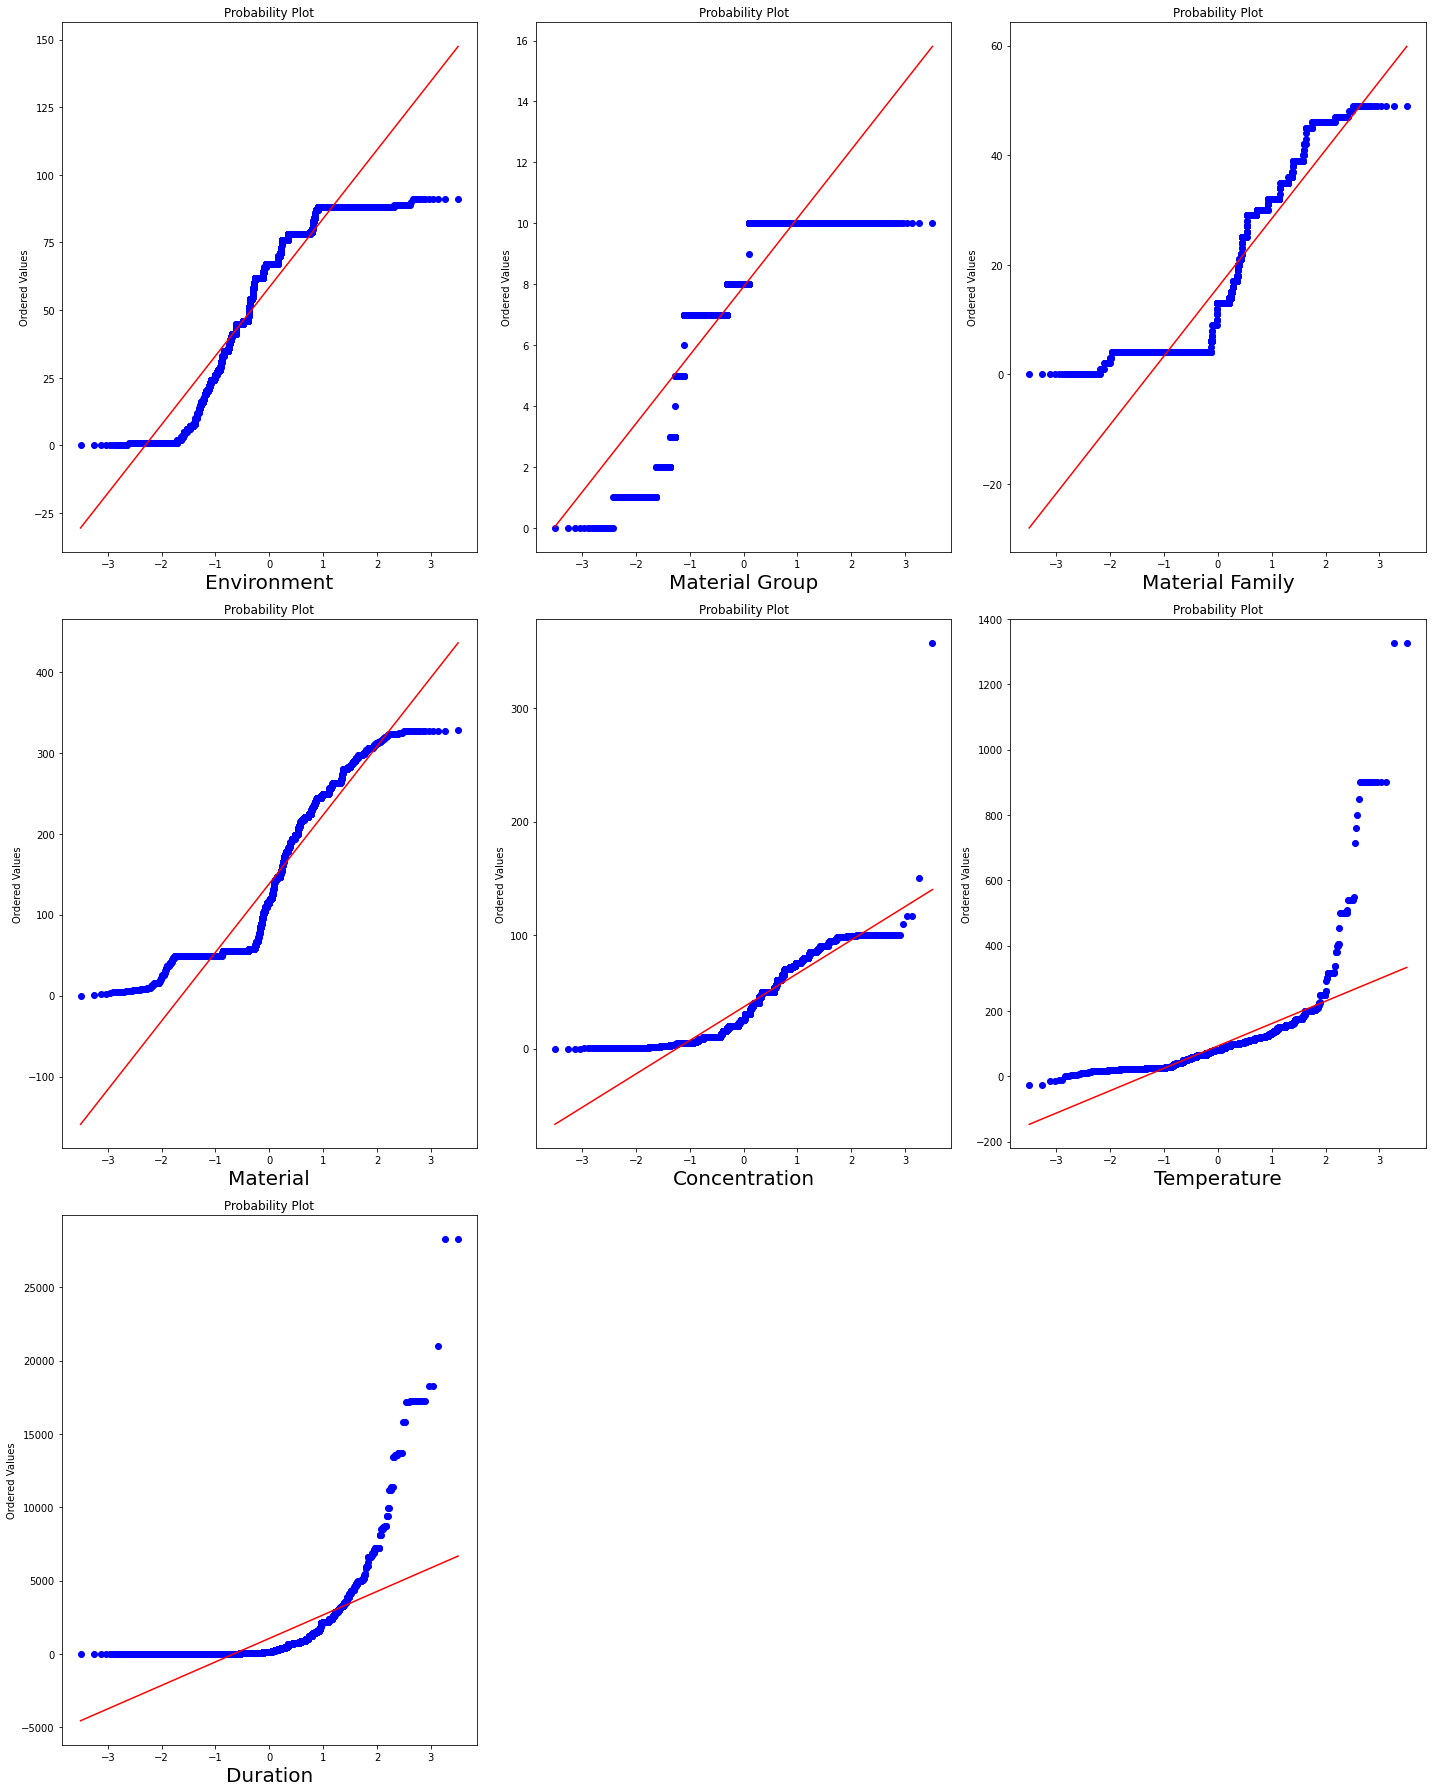

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data_cleaned:
    if plotnumber<=7 :
        ax = plt.subplot(3,3,plotnumber)
        stats.probplot(data_cleaned[column], plot=plt)
        plt.xlabel(column,size=20)
    plotnumber+=1
plt.tight_layout()

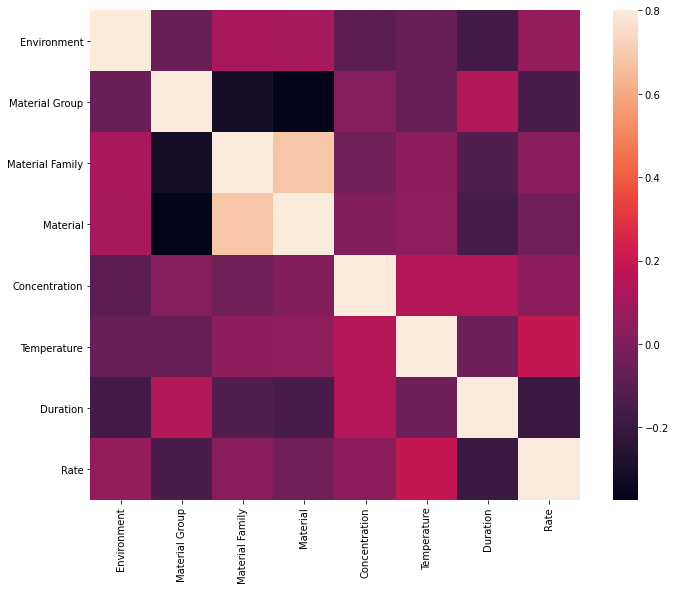

In [ ]:
correlation_matrix = data_cleaned.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

Let's check the multicollinearity of our data by checking the Variance Inflation factor (vif)

In [ ]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(x)
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = x.columns
print("The VIF for the given dataset is\n",vif)

The VIF for the given dataset is
         vif         Features
0  1.047727      Environment
1  1.181644   Material Group
2  1.898464  Material Family
3  2.009144         Material
4  1.056190    Concentration
5  1.034555      Temperature
6  1.079327         Duration


So, the VIF is less than 5. Hence our dataset is good to go. So, we will download the dataset for using it in our model.

In [ ]:
data_cleaned.to_csv('data_cleaned_final_edited')

In [ ]:
data_cleaned.skew()

Environment       -0.734587
Material Group    -1.421304
Material Family    0.730758
Material           0.423072
Concentration      0.910831
Temperature        5.782913
Duration           4.775991
Rate              -0.539670
dtype: float64

In [ ]:
data_cleaned.kurtosis()

Environment        -0.631595
Material Group      1.398590
Material Family    -0.810578
Material           -1.240326
Concentration       2.546333
Temperature        52.321187
Duration           31.799908
Rate               -1.280841
dtype: float64